In [59]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, BaseMessage
import os
from pydantic import BaseModel, Field
import operator
from langgraph.checkpoint.memory import MemorySaver

In [60]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
import requests
import random



In [61]:
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

In [62]:
model = ChatGoogleGenerativeAI(
    model= "gemini-2.5-pro",
    temperature=1.0,
    max_retries=2,
    google_api_key=api_key,
)

In [63]:
search_tool = DuckDuckGoSearchRun() 

@tool
def calculator(first_num : float, second_num: float, operation: str) -> dict :
    """
    Perform a basic arithmetic operation on two numbers, 
    supported opertion:add sub, mul
    """
    if operation=="add":
        result = first_num+second_num
    if operation=="sub":
        result = first_num-second_num
    if operation=="mul":
        result = first_num*second_num
    print("hello wold")
    return {
        "first_num":first_num,
        "second_num": second_num,
        "operation" : operation,
        "result" : result
    } 

tools = [search_tool, calculator]
model_with_tools = model.bind_tools(tools)

In [64]:
from langgraph.graph.message import add_messages
class chatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
   

In [65]:
def chat_node(state: chatState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages" : [response]}

tool_node = ToolNode(tools) 

In [70]:
checkpointer = MemorySaver()
graph = StateGraph(chatState)

# add nodes
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

# add edges
graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
#graph.add_edge("tools", "chat_node")

# compile graph
workflow = graph.compile(checkpointer=checkpointer)

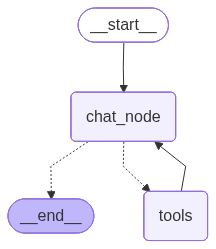

In [67]:
workflow

In [68]:
initial_state = {
    "messages": [HumanMessage(content="Hello, how are you?")]
}
final_state = workflow.invoke(initial_state)
print(final_state["messages"][-1].content)

ValueError: Checkpointer requires one or more of the following 'configurable' keys: thread_id, checkpoint_ns, checkpoint_id

In [72]:
thread_id = '1'
while True:
    chat = input("")
    print(chat)
    if (chat=="exit") :
        break
    else :
        config = {'configurable': {'thread_id': thread_id}}
        response = workflow.invoke({ "messages": [HumanMessage(content={chat})]}, config=config)
        print(response["messages"][-1].content)
    

what is top news in  india today
Top - India - news - today ... info@truescoopnews.com ... Copyright © 2025 TrueScoop News . ... News 24 is your stop for those who are inquisitive enough to keep abreast with the ... Today News Headlines in India : Stay Updated with DLSNews24 ... News 24 is your stop for those who are inquisitive enough to keep abreast with the ... Today News Headlines in India : Stay Updated with DLSNews24 Reuters India News | Reuters India Top News | Reuters India Today News Get the Latest Reuters India News from Business, Finance, Technology, Sports ... Home News Today ’s Trending News : Top Headlines in India and ... Today ’s Trending News : Top Headlines in India and World Updates (August 25, 2025)
exit
